# 3 - Plot

## Load all results data and compute mean & std

In [17]:
import numpy as np
import os

PROJ_DIR = os.path.realpath(os.path.dirname(os.path.abspath('')))

keys = ['correct_pairings_inv', 'correct_pairings_basX', 'spearman_inv', 'spearman_basX', 'aucs_inv', 'aucs_basX', 'spearman_exceptional_inv', 'spearman_exceptional_basX']

result_dict = {}

DATASET_NAME = 'imagenet'
MODEL_NAME = 'resnet50w'
GENERATION_MODE = '_genetic'

num_files = 0 # Count how many files are involved for use below

for f in os.listdir(os.path.join(PROJ_DIR, 'results')):
    if f.startswith(DATASET_NAME) and f.endswith(f'{MODEL_NAME}{GENERATION_MODE}_results.npz'):
        FILENAME = os.path.join(PROJ_DIR, 'results', f)
        num_files += 1
        with np.load(FILENAME) as data:
            for k in keys:
                d = np.expand_dims(data[k], axis=0)
                if k in result_dict:
                    result_dict[k] = np.vstack((result_dict[k], d))
                else:
                    result_dict[k] = d

for k in keys:
    result_dict[f'{k}_mean'] = np.nanmean(result_dict[k], axis=0)
    result_dict[f'{k}_std'] = np.nanstd(result_dict[k], axis=0)

# DEBUG
#print(result_dict['spearman_inv'])
#print(result_dict['spearman_inv_mean'])
#print(result_dict['spearman_basX'])
#print(result_dict['spearman_basX_mean'])

10genetic 0.2290  |  0.4374  |  0.2108  |  0.0840  |  0.0275  |  0.0084  |  0.0029
30genetic 0.1976  |  0.4172  |  0.2184  |  0.1021  |  0.0396  |  0.0168  |  0.0083
40genetic 0.2196  |  0.4200  |  0.2158  |  0.0940  |  0.0339  |  0.0110  |  0.0057
20genetic 0.2138  |  0.4547  |  0.2176  |  0.0813  |  0.0254  |  0.0057  |  0.0015
50genetic 0.2126  |  0.4452  |  0.2165  |  0.0871  |  0.0285  |  0.0076  |  0.0025


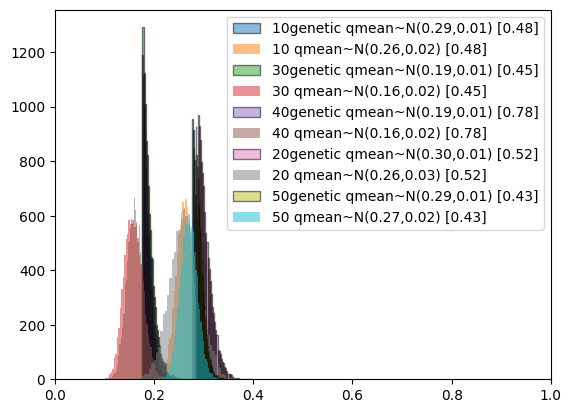

[[0.229  0.4374 0.2108 0.084  0.0275 0.0084 0.0029]
 [0.1976 0.4172 0.2184 0.1021 0.0396 0.0168 0.0083]
 [0.2196 0.42   0.2158 0.094  0.0339 0.011  0.0057]
 [0.2138 0.4547 0.2176 0.0813 0.0254 0.0057 0.0015]
 [0.2126 0.4452 0.2165 0.0871 0.0285 0.0076 0.0025]]


In [26]:
import matplotlib.pyplot as plt

boundaries = [0.5, 1, 1.5, 2, 2.5, 3, 3.5]
counts_by_sigma_level =  np.zeros((num_files, len(boundaries)))
filenames = []
qmean_means = []
qmean_stds = []

# Genetic datasets need the distribution parameters of the random datasets, so load all dataset counts
import json
DATA_PATH = os.path.join(PROJ_DIR,'assets','data')
with open(os.path.join(DATA_PATH, 'dataset-counts.json')) as fIn:
    datasets = json.load(fIn)

current_file_num = 0
for f in os.listdir(os.path.join(PROJ_DIR, 'results')):
    if f.startswith(DATASET_NAME) and f.endswith(f'{MODEL_NAME}{GENERATION_MODE}_measures.npz'):
        FILENAME = os.path.join(PROJ_DIR, 'results', f)
        filenames.append(f)
        short_filename = f.replace("_measures.npz", "").replace(DATASET_NAME, "").replace(MODEL_NAME, "").replace("_", "").replace("-", "")
        with np.load(FILENAME) as data:
            activation = data['output_curves'][8][-1]
            plt.hist(data['qmeans'],\
                    alpha = 0.5,\
                    label = f'{short_filename} qmean~N({np.mean(data["qmeans"]):.2f},{np.std(data["qmeans"]):.2f}) [{activation:.2f}]',\
                    edgecolor='black',\
                    bins = 50\
                    )
            plt.xlim(0,1)

            if GENERATION_MODE == '_genetic':
                with np.load(FILENAME.replace('_genetic', '')) as data_ref:
                    activation_ref = data_ref['output_curves'][8][-1]
                    plt.hist(data_ref['qmeans'],\
                            alpha = 0.5,\
                            label = f'{short_filename.replace("genetic", "")} qmean~N({np.mean(data_ref["qmeans"]):.2f},{np.std(data_ref["qmeans"]):.2f}) [{activation_ref:.2f}]',\
                            bins = 50\
                            )
                    plt.xlim(0,1)

            exceptional_counts = []
            # Compute z-score
            if GENERATION_MODE == '_genetic':
                qmean_mean = float(datasets[DATASET_NAME][f.replace('_genetic','')]['mean'])
                qmean_std = float(datasets[DATASET_NAME][f.replace('_genetic','')]['std'])
            else:
                qmean_mean = np.mean(data["qmeans"])
                qmean_std = np.std(data["qmeans"])
                print(qmean_mean)
                qmean_means.append(qmean_mean)
                qmean_stds.append(qmean_std)
            
            z_scores = ((data["qmeans"] - qmean_mean) / qmean_std).flatten()

            # Count exceptional rankings
            for i in range(1,len(boundaries)+1):
                bottom_limit = boundaries[i-1]
                top_limit = float('inf')
                if i < len(boundaries):
                    top_limit = boundaries[i]
                fraction_count = np.sum(np.logical_and(bottom_limit<=z_scores, z_scores<top_limit).astype(float) / z_scores.shape[0])
                exceptional_counts.append(fraction_count)
                counts_by_sigma_level[current_file_num, i - 1] = fraction_count
            print(f'{short_filename} {"  |  ".join((map(lambda x: f"{x:.4f}", exceptional_counts)))}')
        current_file_num += 1
plt.legend()
plt.savefig(os.path.join(PROJ_DIR, 'results', 'plots', f'{DATASET_NAME}_{MODEL_NAME}{GENERATION_MODE}_qmean_dists.png'))
plt.show()

print(counts_by_sigma_level)

In [19]:
dataset_counts = {} if DATASET_NAME not in datasets else datasets[DATASET_NAME]
for i, f in enumerate(filenames):
    if GENERATION_MODE == '_genetic':
        dataset_counts[f.replace('_genetic', '')]['counts_genetic'] = list(counts_by_sigma_level[i])
    else:
        dataset_counts[f] = {'counts':list(counts_by_sigma_level[i]), 'mean': str(qmean_means[i]), 'std': str(qmean_stds[i])}

datasets[DATASET_NAME] = dataset_counts

with open(os.path.join(DATA_PATH, 'dataset-counts.json'), 'w') as fOut:
    json.dump(datasets, fOut)

## Plot correct pairings

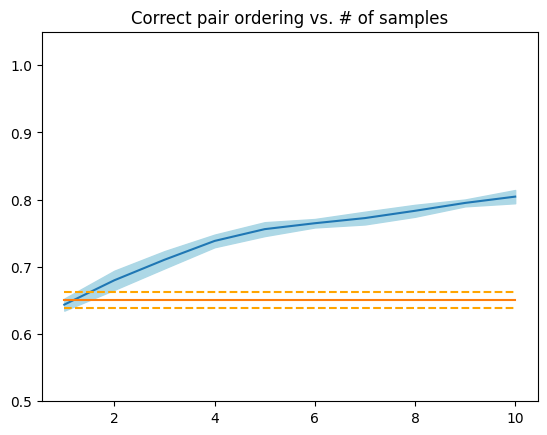

In [20]:
plt.fill_between(range(1,11), result_dict['correct_pairings_basX_mean']+result_dict['correct_pairings_basX_std'], result_dict['correct_pairings_basX_mean']-result_dict['correct_pairings_basX_std'], color='lightblue')
plt.plot(range(1,11),result_dict['correct_pairings_basX_mean'])
plt.title('Correct pair ordering vs. # of samples')
plt.plot([1,10], [result_dict['correct_pairings_inv_mean']+result_dict['correct_pairings_inv_std'], result_dict['correct_pairings_inv_mean']+result_dict['correct_pairings_inv_std']], color='orange', linestyle = 'dashed')
plt.plot([1,10], [result_dict['correct_pairings_inv_mean']-result_dict['correct_pairings_inv_std'], result_dict['correct_pairings_inv_mean']-result_dict['correct_pairings_inv_std']], color='orange', linestyle = 'dashed')
plt.plot([1,10],[result_dict['correct_pairings_inv_mean'],result_dict['correct_pairings_inv_mean']])
plt.ylim(0.5,1.05)
plt.savefig(os.path.join(PROJ_DIR, 'results', 'plots', f'{DATASET_NAME}_{MODEL_NAME}{GENERATION_MODE}_correct_pairs.png'))
plt.show()

## Plot Spearman correlation

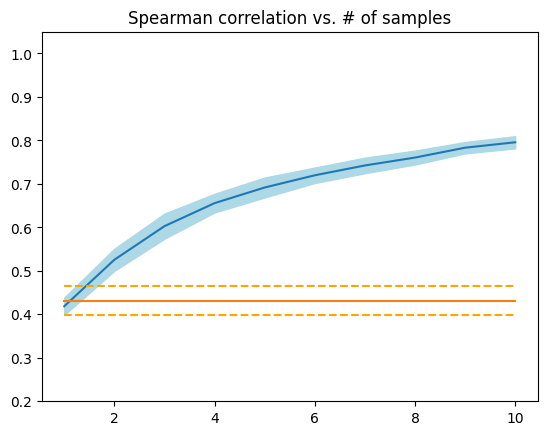

In [21]:
plt.fill_between(range(1,11), result_dict['spearman_basX_mean']+result_dict['spearman_basX_std'], result_dict['spearman_basX_mean']-result_dict['spearman_basX_std'], color='lightblue')
plt.plot(range(1,11),result_dict['spearman_basX_mean'])
plt.title('Spearman correlation vs. # of samples')
plt.plot([1,10], [result_dict['spearman_inv_mean']+result_dict['spearman_inv_std'], result_dict['spearman_inv_mean']+result_dict['spearman_inv_std']], color='orange', linestyle = 'dashed')
plt.plot([1,10], [result_dict['spearman_inv_mean']-result_dict['spearman_inv_std'], result_dict['spearman_inv_mean']-result_dict['spearman_inv_std']], color='orange', linestyle = 'dashed')
plt.plot([1,10],[result_dict['spearman_inv_mean'],result_dict['spearman_inv_mean']])
plt.ylim(0.2,1.05)
plt.savefig(os.path.join(PROJ_DIR, 'results', 'plots', f'{DATASET_NAME}_{MODEL_NAME}{GENERATION_MODE}_spearman.png'))
plt.show()

## Plot ability to detect exceptional rankings

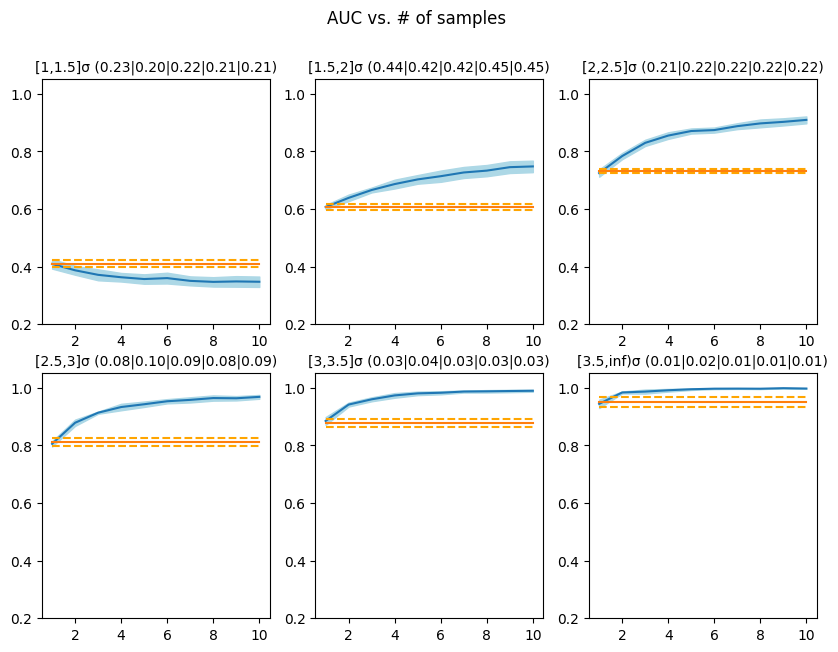

In [22]:
boundaries = [0.5, 1, 1.5, 2, 2.5, 3, 3.5]

fig, axes = plt.subplots(2, 3, figsize=(10, 7))
for i, ax in enumerate(axes.flat):
    ax.fill_between(range(1,11), result_dict['aucs_basX_mean'][:,i+1]+result_dict['aucs_basX_std'][:,i+1], result_dict['aucs_basX_mean'][:,i+1]-result_dict['aucs_basX_std'][:,i+1], color='lightblue')
    ax.plot(range(1,11),result_dict['aucs_basX_mean'][:,i+1])
    counts_str = '|'.join(map(lambda x:f'{x:.2f}',counts_by_sigma_level[:, i]))
    if i<len(boundaries)-2:
        ax.set_title(f'[{boundaries[i+1]},{boundaries[i+1+1]}]σ ({counts_str})', fontsize=10)
    else:
        ax.set_title(f'[{boundaries[i+1]},inf)σ ({counts_str})', fontsize=10)
    ax.plot([1,10], [result_dict['aucs_inv_mean'][i+1]+result_dict['aucs_inv_std'][i+1], result_dict['aucs_inv_mean'][i+1]+result_dict['aucs_inv_std'][i+1]], color='orange', linestyle = 'dashed')
    ax.plot([1,10], [result_dict['aucs_inv_mean'][i+1]-result_dict['aucs_inv_std'][i+1], result_dict['aucs_inv_mean'][i+1]-result_dict['aucs_inv_std'][i+1]], color='orange', linestyle = 'dashed')
    ax.plot([1,10],[result_dict['aucs_inv_mean'][i+1],result_dict['aucs_inv_mean'][i+1]])
    ax.set_ylim(0.2,1.05)
plt.suptitle('AUC vs. # of samples')
plt.savefig(os.path.join(PROJ_DIR, 'results', 'plots', f'{DATASET_NAME}_{MODEL_NAME}{GENERATION_MODE}_auc_exceptional.png'))
plt.show()
plt.close(fig)

## Plot Spearman correlation for exceptional rankings

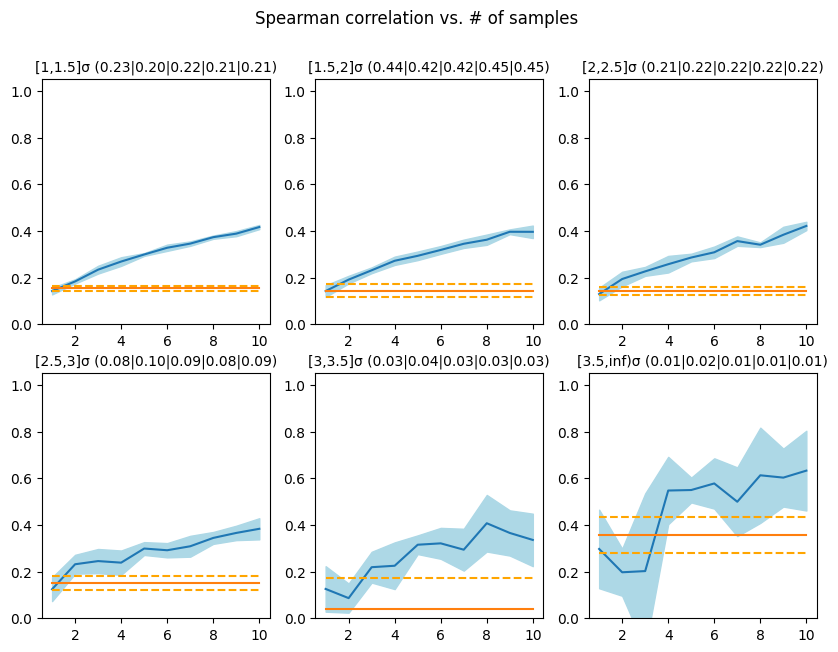

In [23]:
boundaries = [0.5, 1, 1.5, 2, 2.5, 3, 3.5]

fig, axes = plt.subplots(2, 3, figsize=(10, 7))
for i, ax in enumerate(axes.flat):
    ax.fill_between(range(1,11), result_dict['spearman_exceptional_basX_mean'][:,i+1]+result_dict['spearman_exceptional_basX_std'][:,i+1], result_dict['spearman_exceptional_basX_mean'][:,i+1]-result_dict['spearman_exceptional_basX_std'][:,i+1], color='lightblue')
    ax.plot(range(1,11),result_dict['spearman_exceptional_basX_mean'][:,i+1])
    counts_str = '|'.join(map(lambda x:f'{x:.2f}',counts_by_sigma_level[:, i]))
    if i<len(boundaries)-2:
        ax.set_title(f'[{boundaries[i+1]},{boundaries[i+1+1]}]σ ({counts_str})', fontsize=10)
    else:
        ax.set_title(f'[{boundaries[i+1]},inf)σ ({counts_str})', fontsize=10)
    ax.plot([1,10], [result_dict['spearman_exceptional_inv_mean'][i+1]+result_dict['spearman_exceptional_inv_std'][i+1], result_dict['spearman_exceptional_inv_mean'][i+1]+result_dict['spearman_exceptional_inv_std'][i+1]], color='orange', linestyle = 'dashed')
    ax.plot([1,10], [result_dict['spearman_exceptional_inv_mean'][i+1]-result_dict['spearman_exceptional_inv_std'][i+1], result_dict['spearman_exceptional_inv_mean'][i+1]-result_dict['spearman_exceptional_inv_std'][i+1]], color='orange', linestyle = 'dashed')
    ax.plot([1,10],[result_dict['spearman_exceptional_inv_mean'][i+1],result_dict['spearman_exceptional_inv_mean'][i+1]])
    ax.set_ylim(0,1.05)
plt.suptitle('Spearman correlation vs. # of samples')
plt.savefig(os.path.join(PROJ_DIR, 'results', 'plots', f'{DATASET_NAME}_{MODEL_NAME}{GENERATION_MODE}_spearman_exceptional.png'))
plt.show()

## Plot correct pairings vs z-index

imagenet_10_resnet50w_genetic_measures.npz


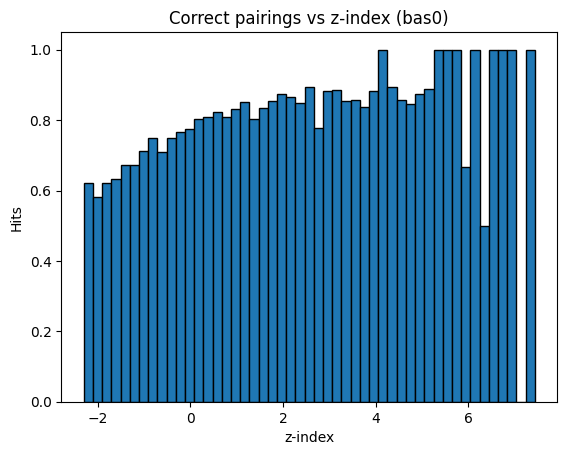

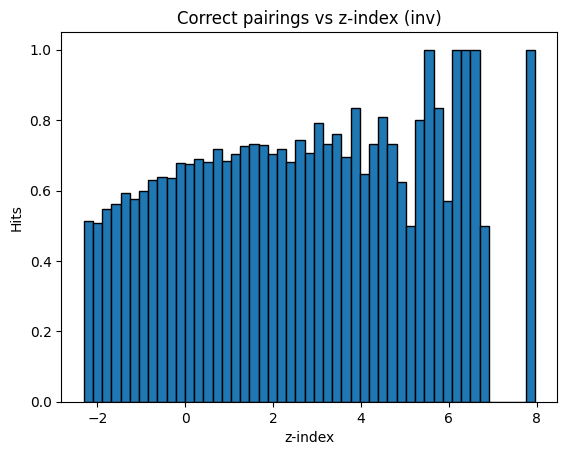

imagenet_30_resnet50w_genetic_measures.npz


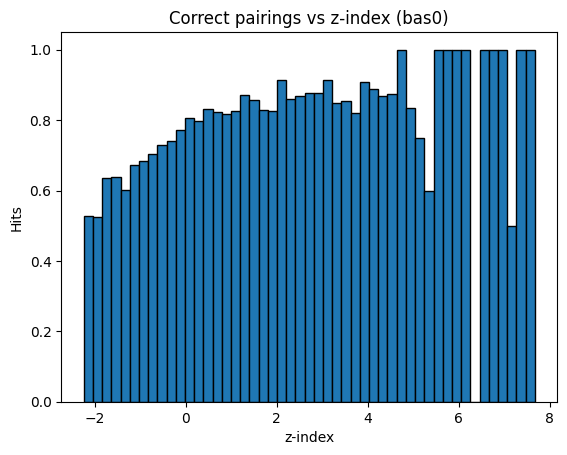

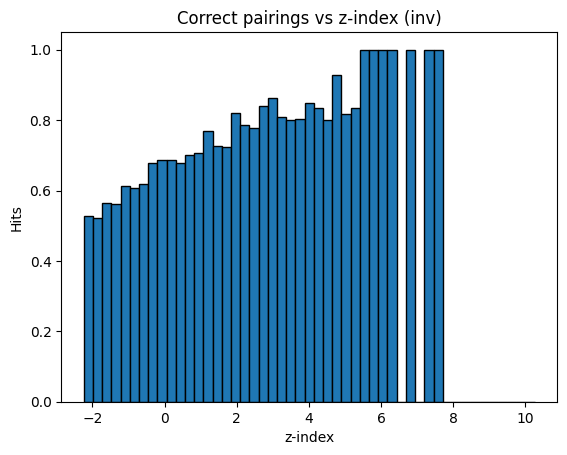

imagenet_40_resnet50w_genetic_measures.npz


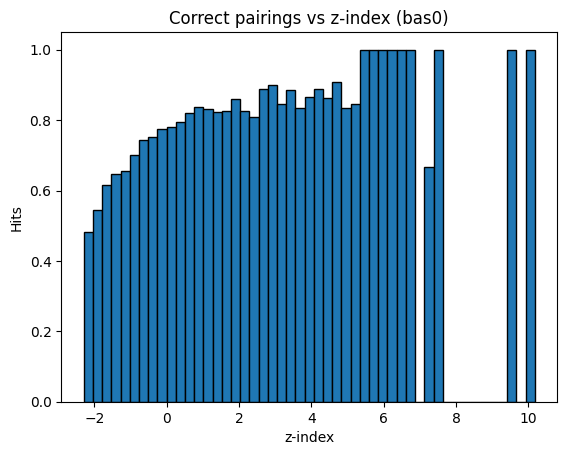

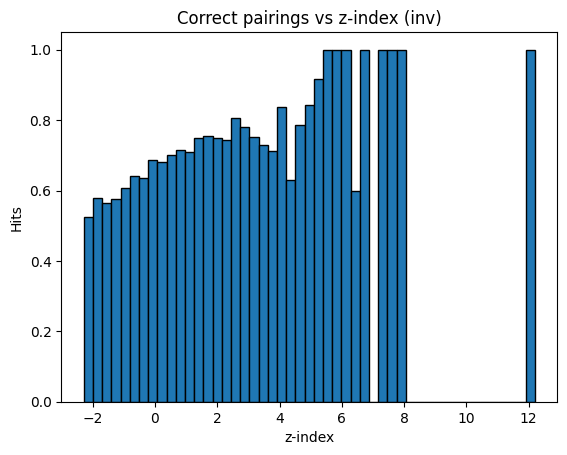

imagenet_20_resnet50w_genetic_measures.npz


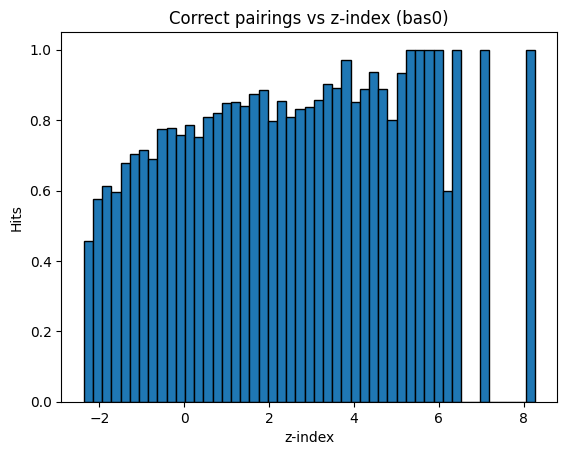

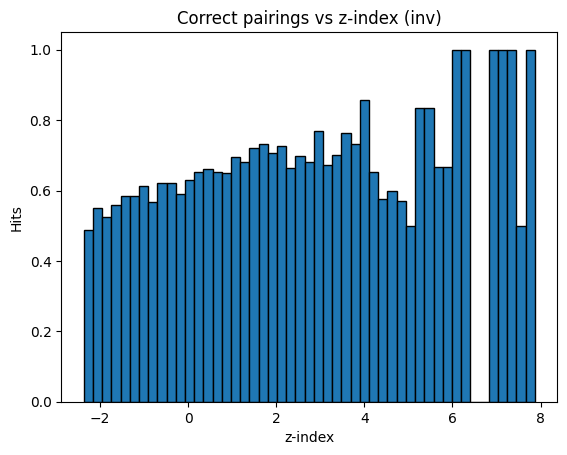

imagenet_50_resnet50w_genetic_measures.npz


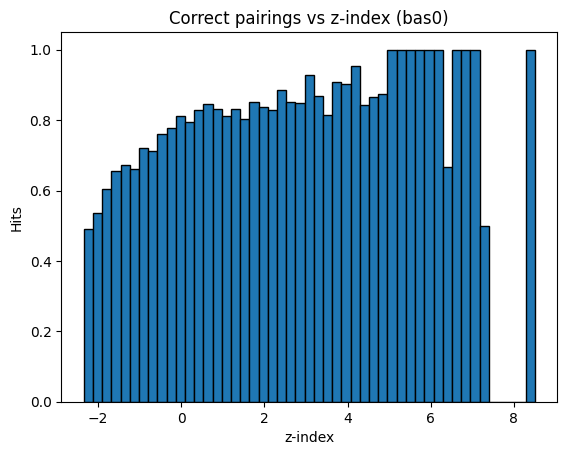

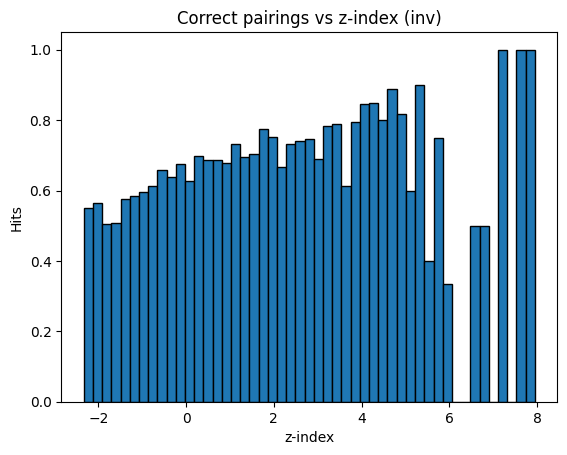

In [24]:
import sys
sys.path.append(os.path.join(PROJ_DIR,'src'))
import xai_faithfulness_experiments_lib_edits as ff

for FILENAME in os.listdir(os.path.join(PROJ_DIR,'results')):
    if FILENAME.startswith(DATASET_NAME) and FILENAME.endswith(f'{MODEL_NAME}{GENERATION_MODE}_measures.npz'):
        print(FILENAME)

        # Load data
        data = ff.load_generated_data(os.path.join(PROJ_DIR, 'results', FILENAME))
        qmeans = data['qmeans']
        #qmeans_basX = [data['qmean_bas']] # We don't look at qmean_bas, it will be recomputed later with the appropriate reference
        qmeans_basX = []
        qmeans_inv = data['qmean_invs']

        # Compute qmeans_bas[2-10]
        def compute_qbas(measure, num_samples, reference:np.ndarray):
            random_indices = np.random.randint(0,  reference.shape[0], (reference.shape[0], num_samples))
            random_qmeans = reference[random_indices]
            mean = np.mean(random_qmeans, axis=1)

            # First way to deal with std==0; add some epsilon
            #std = np.std(random_qmeans, axis=1) + 1e-10

            # Second way to deal with std==0; ignore std (divide by 1)
            std = np.std(random_qmeans, axis=1)
            std[std==0] = 1

            # Always ignore std
            std=1
            return (measure - mean) / std
        for i in range(1,11):
            # If data is genetic, compute qbas with random data from other file
            qmeans_basX.append(compute_qbas(qmeans, i, qmeans))

        # Compute z-score
        qmean_mean = np.mean(qmeans)
        qmean_std = np.std(qmeans)

        z_scores = ((qmeans - qmean_mean) / qmean_std).flatten()

        def correct_orderings_by_zscore(truths, estimators, zscore):
            '''
            Creates len(truth) x,y pairs and computes the fraction of them for which (truths[x]<truths[y] and estimators[x]<estimators[y]) or (truths[x]>truths[y] and estimators[x]>estimators[y])
            Inputs:
                - Truths & estimators contain num_elems floats
            Output:
                - Float representing the fraction of correctly ordered pairings
            '''
            xs = np.random.permutation(truths.size)
            ys = np.random.permutation(truths.size)
            truthX_lt_Y = truths[xs] < truths[ys]
            estimatorX_lt_Y = estimators[xs] < estimators[ys]
            hits = truthX_lt_Y==estimatorX_lt_Y
            return np.hstack((hits, np.expand_dims(zscore[xs]+zscore[ys], axis=1)))

        def plot_hits_vs_zindex(correct_orderings_by_zscore, name):
            # Define y as the bin edges, here we're just using the unique y values as edges
            y_values = correct_orderings_by_zscore[:, 1]

            # The number of bins should be one less than the number of unique y values
            # because in histogram bins are between the edges
            bins = np.linspace(y_values.min(), y_values.max(), 50)

            # Use the x values as weights and the y values to determine the bins
            sum_hist, edges = np.histogram(y_values, bins=bins, weights=correct_orderings_by_zscore[:, 0])

            # Now get the counts in each y bin to calculate the average
            count_hist, _ = np.histogram(y_values, bins=bins)

            # Avoid division by zero by replacing zero counts with NaN (or another value)
            # This will give a NaN result for average where count is zero
            averages = np.divide(sum_hist, count_hist, out=np.zeros_like(sum_hist), where=count_hist!=0)

            # Plotting the average x values for each bin of y
            plt.bar(edges[:-1], averages, width=np.diff(edges), edgecolor="black", align="edge")

            plt.xlabel('z-index')
            plt.ylabel('Hits')
            plt.title(f'Correct pairings vs z-index ({name})')
            plt.show()

        correct_pairings_basX = []
        for i in range(len(qmeans_basX)):
            correct_pairings_basX = correct_orderings_by_zscore(qmeans, qmeans_basX[i], z_scores)
            plot_hits_vs_zindex(correct_pairings_basX, f'bas{i}')
            break
        
        correct_pairings_inv = correct_orderings_by_zscore(qmeans, qmeans_inv, z_scores)
        plot_hits_vs_zindex(correct_pairings_inv, 'inv')